## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

/Users/lfiaschi/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Helper Functions

In [142]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image, mask


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def average_lines(lines):

    def compute_coef(line):
        line= list(line.flatten())
        x1,y1,x2,y2 = line
        m = (y2-y1)/(x2-x1)
        b = y1-m*x1
        return m, b

    def m_b_to_points(m,b):

        y1=540
        x1=(y1-b)/ m

        y2=320
        x2=(y2-b)/ m
        return int(x1),int(y1),int(x2),int(y2)
    
    left_line = list()
    right_line = list()
    for line in lines:
        m, b = compute_coef(line)
        if  m> 0:
            left_line.append((m,b))
        else:
            right_line.append((m,b))

    left_line = np.array(left_line)
    right_line = np.array(right_line)
    left_line = np.median(left_line,axis=0)
    right_line = np.median(right_line,axis=0)
    right_line = m_b_to_points(*right_line)
    left_line = m_b_to_points(*left_line)
    return np.array([left_line,right_line])



def hough_lines2(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    This version averages multiple lines to find robust left and right lane
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines = average_lines(lines)

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    color=[255, 0, 0]
    thickness=6
    for line in lines:
        x1,y1,x2,y2 = list(line)
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    
    return line_img, lines

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

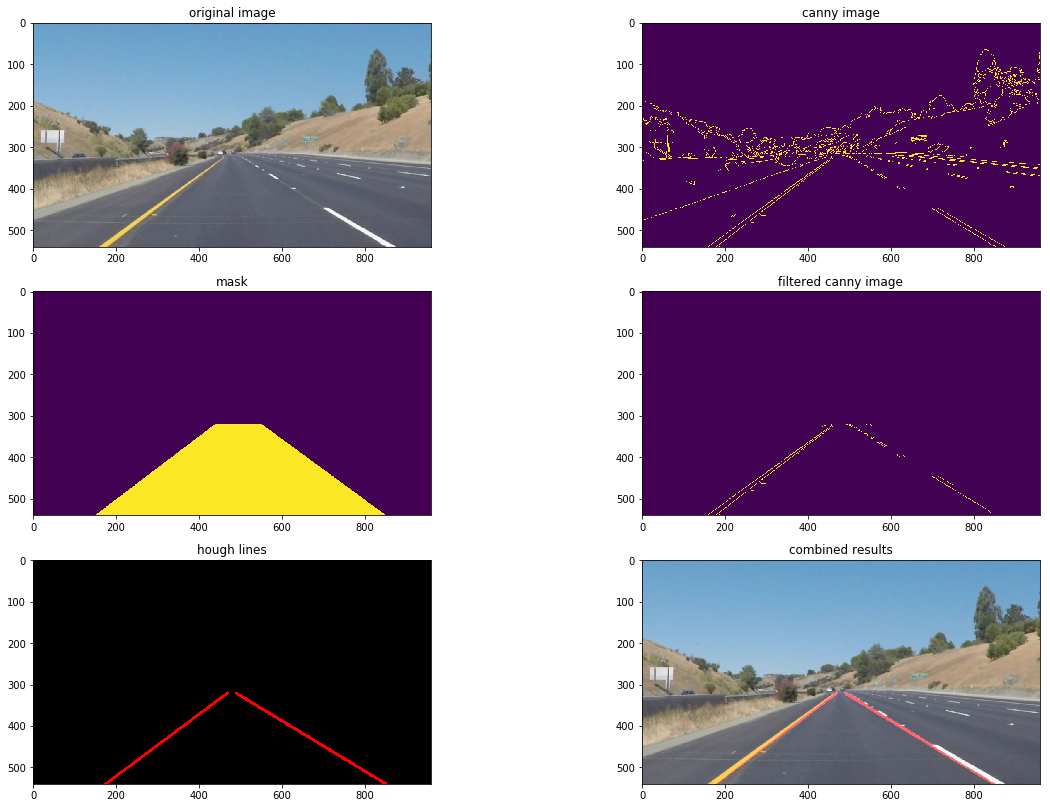

In [240]:
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image_gray  = grayscale(image)
image_blur = gaussian_blur(image_gray,7)
canny_map = canny(image, 45, 180)
poly_edges = np.array([[[150,540],[440,320],[550,320],[850,540]]],dtype=np.int32)


canny_map_filtered, mask = region_of_interest(canny_map,poly_edges)

mask1 = mask.copy()
mask2 = mask.copy()

mask1[:,500:] =0
mask2[:,500:] =0


hough_img,lines = hough_lines2(canny_map_filtered,rho=2,theta=np.pi/180,threshold=15, min_line_len=40,max_line_gap=20)


plt.figure(figsize=(20,14))
plt.subplot(3,2,1)
plt.title('original image')
plt.imshow(image)
plt.subplot(3,2,2)
plt.title('canny image')
plt.imshow(canny_map)
plt.subplot(3,2,3)
plt.title('mask')
plt.imshow(mask)
plt.subplot(3,2,4)
plt.title('filtered canny image')
plt.imshow(canny_map_filtered)
plt.subplot(3,2,5)
plt.title('hough lines')
plt.imshow(hough_img)
plt.subplot(3,2,6)
plt.title('combined results')
plt.imshow(weighted_img(image,hough_img))


In [241]:
def process_image(image):
    image_gray  = grayscale(image)
    image_blur = gaussian_blur(image_gray,7)
    canny_map = canny(image, 45, 180)
    poly_edges = np.array([[[150,540],[440,320],[550,320],[850,540]]],dtype=np.int32)


    canny_map_filtered, mask = region_of_interest(canny_map,poly_edges)

    mask1 = mask.copy()
    mask2 = mask.copy()

    mask1[:,500:] =0
    mask2[:,500:] =0


    hough_img,lines = hough_lines2(canny_map_filtered,rho=2,theta=np.pi/180,threshold=15, min_line_len=40,max_line_gap=20)
    return weighted_img(image,hough_img)

## Test on Videos

In [242]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [243]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 28.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.63 s, sys: 557 ms, total: 5.19 s
Wall time: 8.58 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [235]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [244]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:24<00:00, 27.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 14.6 s, sys: 1.61 s, total: 16.2 s
Wall time: 25.5 s


In [245]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
